In [1]:
from glob import glob
from pathlib import Path
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# def make_predict(path):  
#     feats = {}
#     for file in Path(path).glob("*.txt"):
#         feats = np.loadtxt(file)
#         if len(feats.shape) > 1:
#             np.savetxt(f"./chem_data/to_predict/{file.name}", feats[:2,:])
#         else: 
#             np.savetxt(f"./chem_data/to_predict/{file.name}", feats[:2])

In [3]:
# path = "./chem_data/processed_output_some/0001_simple_cond/"
# make_predict(path)

In [4]:
# !python -m chem_data.chemgns --action='predict' --raw_data_path="./chem_data/to_predict"  --preped_data_path="./gns/prepared_topredict/"

In [5]:
# !python -m gns.train --mode="predict" --data_path="./gns/prepared_topredict/" --model_path="./gns/model/" --output_path="./gns/predicted_rollout" --model_file="model-300.pt" --train_state_file="train_state-300.pt"

# Check Results

In [11]:
import chem_data.analyze_results as ar

In [22]:
help(ar)

Help on module chem_data.analyze_results in chem_data:

NAME
    chem_data.analyze_results

FUNCTIONS
    gd_from_vol(vol)
    
    load_rollout_data(path)
        Load pickle rollout files output by GNS.
        Args:
        path: path to the pickle files (default gns/output/), where each file corresponds to a rollout.
        
        Returns:
        dictionary: keys are string names of the rollout files.
    
    mass_concentration(mass_of_particles, aero_number, chem='all')
    
    mean_std_diameter(mass_of_particles)
    
    nmae(truth, pred)
    
    volume(chem, mass)

DATA
    __warningregistry__ = {'version': 86}
    density_dict = {'BC': 1700, 'H2O': 1000, 'OC': 1000, 'POM': 1200, 'SO4...

FILE
    /home/fabiana/Documents/gns/chem_data/analyze_results.py




In [7]:
material_properties = ['BC', 'OC', 'aero_number']
particle_chems = ['H2O', 'SO4']
gases = ['H2SO4']

In [8]:
rollout_results = "./chem_data/proc_data/"

In [9]:
rollout_data = {}
for dir in os.listdir(rollout_results):
    if dir.startswith("."):  
        print(f"Skipping {dir}")
        continue

    path = rollout_results + dir
    rollout_data[dir] = ar.load_rollout_data(path)

Skipping .ipynb_checkpoints


In [10]:
rollout_data.keys()

dict_keys(['rep8', 'rep2', 'rep13', 'rep14', 'rep20', 'rep9', 'ex6', 'ex5', 'rep7', 'rep12', 'rep1', 'ex4', 'ex2', 'rep18', 'rep5', 'rep19', 'rep3', 'ex3', 'unnorm.pkl', 'ex0', 'rep16', 'rep4', 'rep6', 'rep10', 'rep11', 'rep17', 'ex7', 'ex1', 'ex8', 'rep15', 'extest'])

In [149]:
rollout_data['ex0']['rollout_ex00_dict.pkl'].keys()

dict_keys(['loss', 'true_x', 'pred_x', 'mat_prop'])

In [150]:
loss_dict = {}
for k in rollout_data.keys():
    if (k != 'unnorm.pkl' and not k.startswith('ex')) or k == 'ex0':
        loss_dict[int(re.findall('[0-9]+', k)[0])] = float(rollout_data[k]['rollout_ex00_dict.pkl']['loss'])

In [151]:
losses = sorted(loss_dict.items())

In [152]:
losses

[(0, 0.000687737949192524),
 (1, 3.206225665053353e-05),
 (2, 2.3472055545425974e-05),
 (3, 2.5309036573162302e-05),
 (4, 1.6744861568440683e-05),
 (5, 4.74333774036495e-06),
 (6, 1.8538099766374216e-06),
 (7, 1.1864426596730482e-06),
 (8, 1.0458526958245784e-05),
 (9, 0.0007234530639834702),
 (10, 2.4242137442342937e-05),
 (11, 5.519398200704018e-06),
 (12, 1.7151422071037814e-05),
 (13, 1.1809893294412177e-05),
 (14, 1.208367757499218e-05),
 (15, 8.12563826002588e-07),
 (16, 7.431076483044308e-06),
 (17, 2.3813239749870263e-05),
 (18, 3.997235035058111e-05),
 (19, 2.6082600015797652e-05),
 (20, 0.0001573110930621624)]

In [153]:
xs = [e*100+100 for e, _ in losses]
ys = [l for _, l in losses]

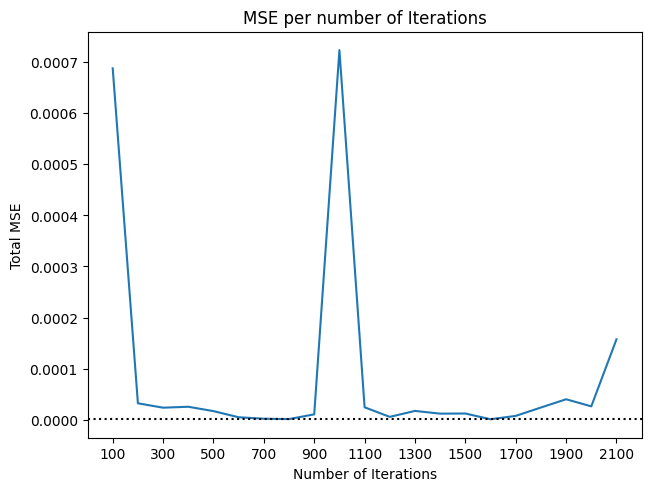

In [154]:
fig, ax = plt.subplots(layout='constrained')
ax.plot(xs, ys)
plt.axhline(y=min(ys), color="black", linestyle=":")
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Total MSE')
ax.set_title('MSE per number of Iterations')
plt.xticks(xs[::2])
plt.savefig("mse.png")

In [155]:
ro = rollout_data['rep15']['rollout_ex00_dict.pkl']

In [156]:
true_x = ro['true_x']
pred_x = ro['pred_x']
mat_prop = ro['mat_prop']

In [157]:
true_x.keys()

dict_keys(['H2O', 'SO4', 'H2SO4'])

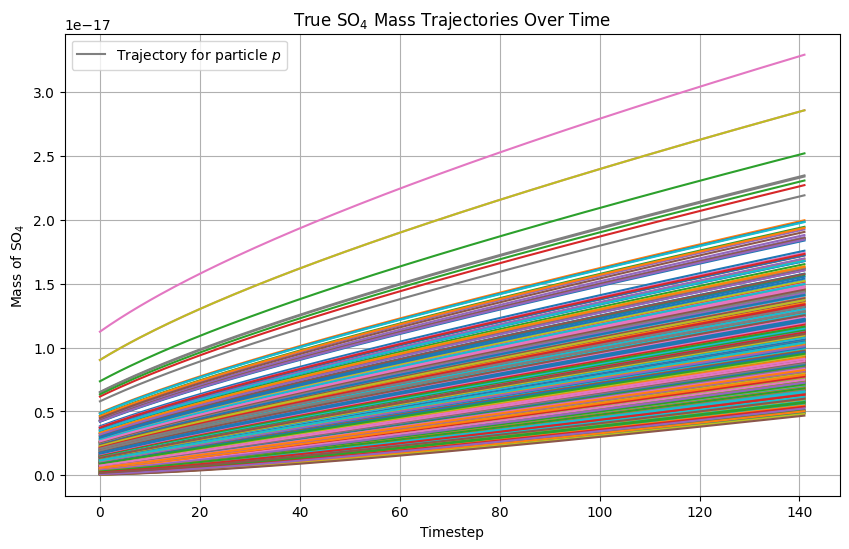

In [158]:
# Plot trajectories
plt.figure(figsize=(10, 6))
plt.plot(true_x['SO4'])

# Add labels and title
plt.xlabel('Timestep')
plt.ylabel('Mass of SO$_4$')
plt.title('True SO$_4$ Mass Trajectories Over Time')

# Add legend for trajectories
plt.plot([], [], color='gray', label='Trajectory for particle $p$')
plt.legend(loc='upper left', frameon=True)

# Show plot
plt.grid(True)
plt.savefig("trueso4rep15.png")

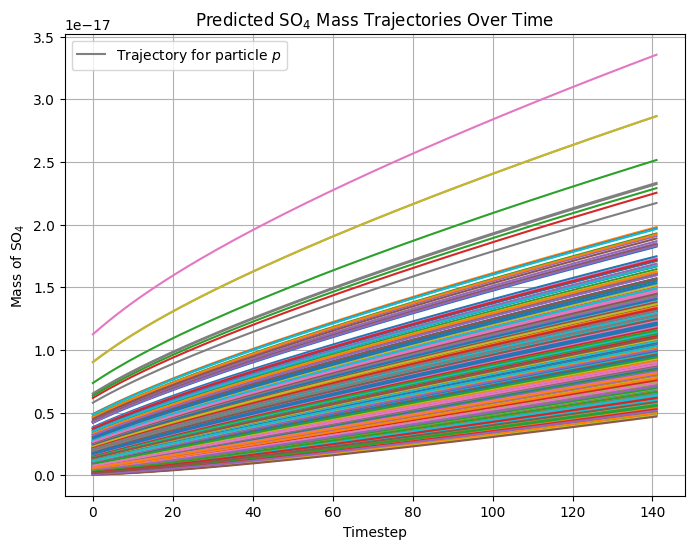

In [159]:
# Plot trajectories
plt.figure(figsize=(8, 6))
plt.plot(pred_x['SO4'])

# Add labels and title
plt.xlabel('Timestep')
plt.ylabel('Mass of SO$_4$')
#plt.xlim(0,144)
plt.title('Predicted SO$_4$ Mass Trajectories Over Time')

# Add legend for trajectories
plt.plot([], [], color='gray', label='Trajectory for particle $p$')
plt.legend(loc='upper left', frameon=True)

# Show plot
plt.grid(True)
plt.savefig("t5so4rep15.png")

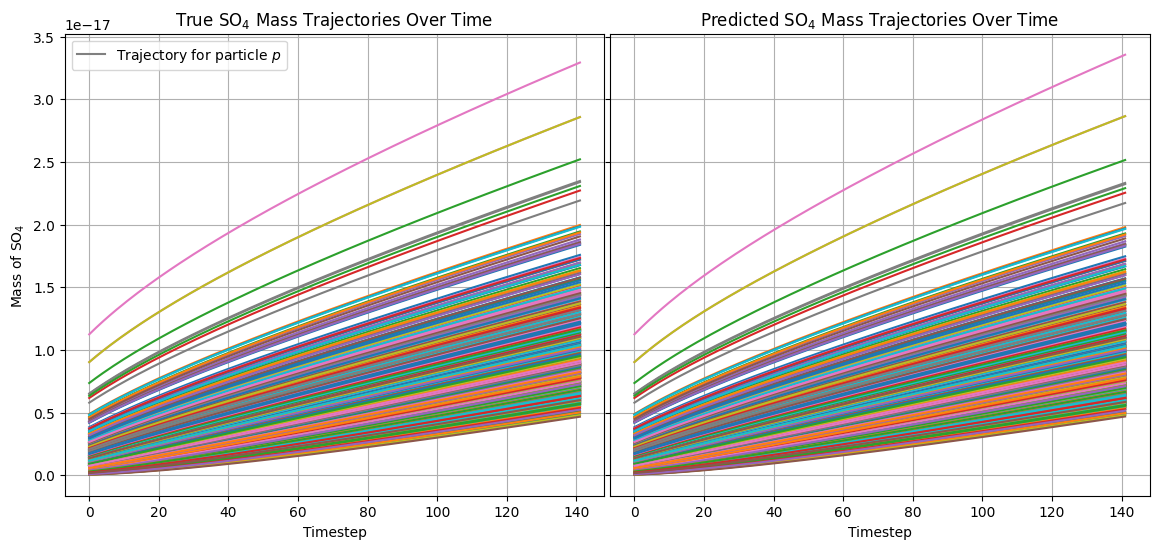

In [160]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)
ax1.plot(true_x['SO4'])
ax2.plot(pred_x['SO4'])

# Add labels and title
ax1.set_xlabel('Timestep')
ax2.set_xlabel('Timestep')
ax1.set_ylabel('Mass of SO$_4$')

ax1.set_title('True SO$_4$ Mass Trajectories Over Time')
ax2.set_title('Predicted SO$_4$ Mass Trajectories Over Time')

# Add legend for trajectories
ax1.plot([], [], color='gray', label='Trajectory for particle $p$')
ax1.legend(loc='upper left', frameon=True)

# Adjust space between subplots
plt.subplots_adjust(wspace=0.01)

# Show plot
ax1.grid(True)
ax2.grid(True)
plt.savefig("so4rep15.png")

In [162]:
ar.nmae(true_x['SO4'], pred_x['SO4'])

0.007092937514747574

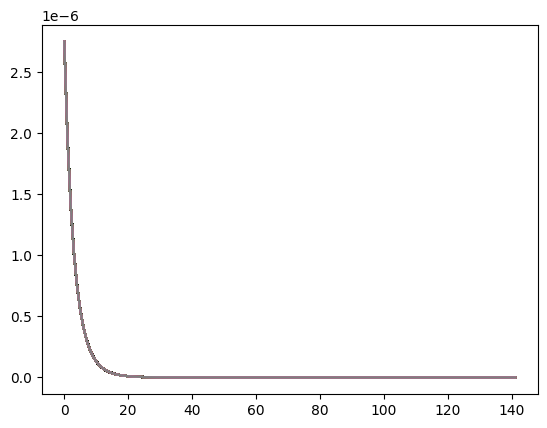

In [163]:
plt.plot(true_x['H2SO4'])
plt.show()

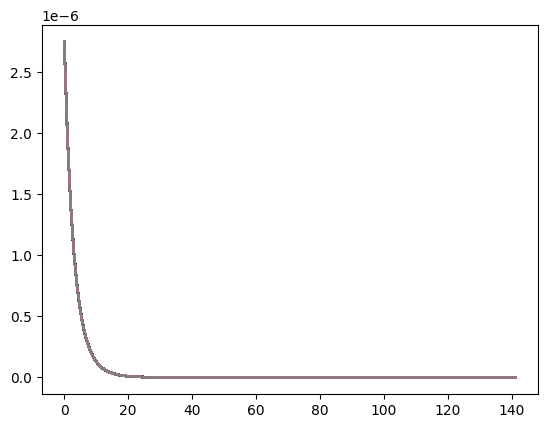

In [164]:
plt.plot(pred_x['H2SO4'])
plt.show()

In [165]:
pred_x['H2SO4'].shape

(142, 808)

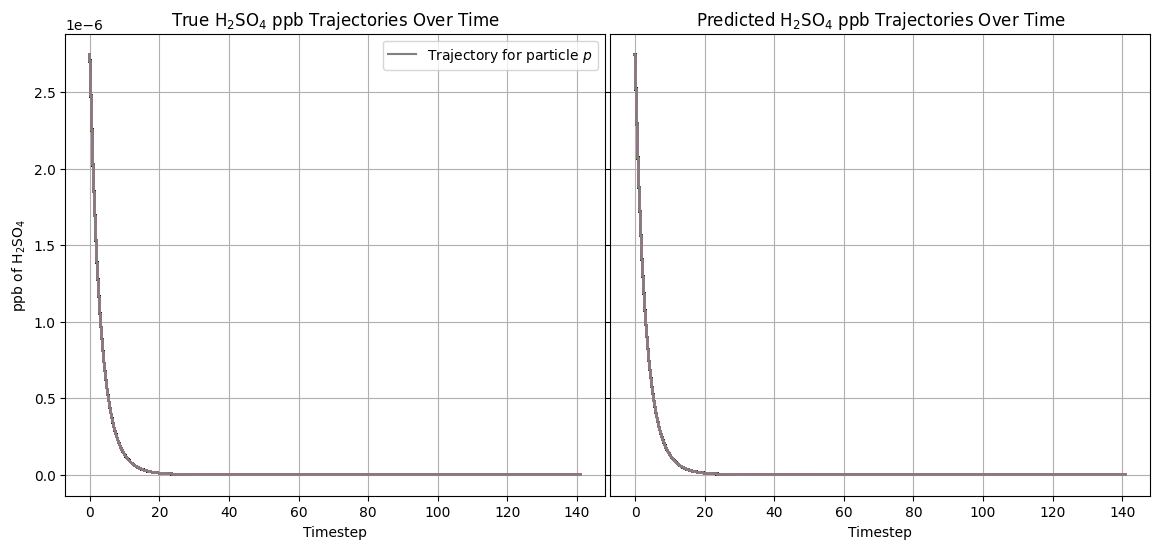

In [166]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)
ax1.plot(true_x['H2SO4'])
ax2.plot(pred_x['H2SO4'])

# Add labels and title
ax1.set_xlabel('Timestep')
ax2.set_xlabel('Timestep')
ax1.set_ylabel('ppb of H$_2$SO$_4$')

ax1.set_title('True H$_2$SO$_4$ ppb Trajectories Over Time')
ax2.set_title('Predicted H$_2$SO$_4$ ppb Trajectories Over Time')

# Add legend for trajectories
ax1.plot([], [], color='gray', label='Trajectory for particle $p$')
ax1.legend(loc='upper right', frameon=True)

# Adjust space between subplots
plt.subplots_adjust(wspace=0.01)

# Show plot
ax1.grid(True)
ax2.grid(True)
plt.savefig("h2so4rep15.png")

In [167]:
ar.nmae(true_x['H2SO4'], pred_x['H2SO4'])

0.010683776936281357

In [168]:
true_dry_mass = {'BC': mat_prop['BC'], 'OC': mat_prop['OC'], 'SO4': true_x['SO4']}

In [169]:
pred_dry_mass = {'BC': mat_prop['BC'], 'OC': mat_prop['OC'], 'SO4': pred_x['SO4']}

In [170]:
so4_diam = ar.gd_from_vol(ar.volume('SO4', true_dry_mass))

In [171]:
pred_so4_diam = ar.gd_from_vol(ar.volume('SO4', pred_dry_mass))

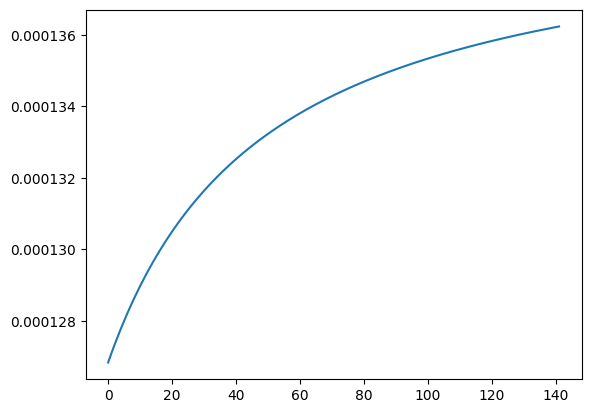

In [172]:
plt.plot(ar.mass_concentration(true_dry_mass, mat_prop['aero_number'], chem='all'))

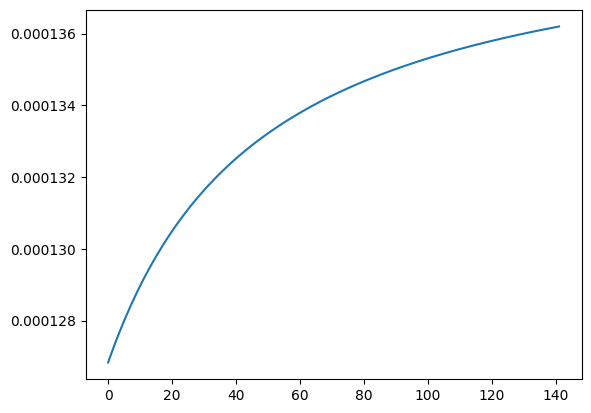

In [173]:
plt.plot(ar.mass_concentration(pred_dry_mass, mat_prop['aero_number'], chem='all'))

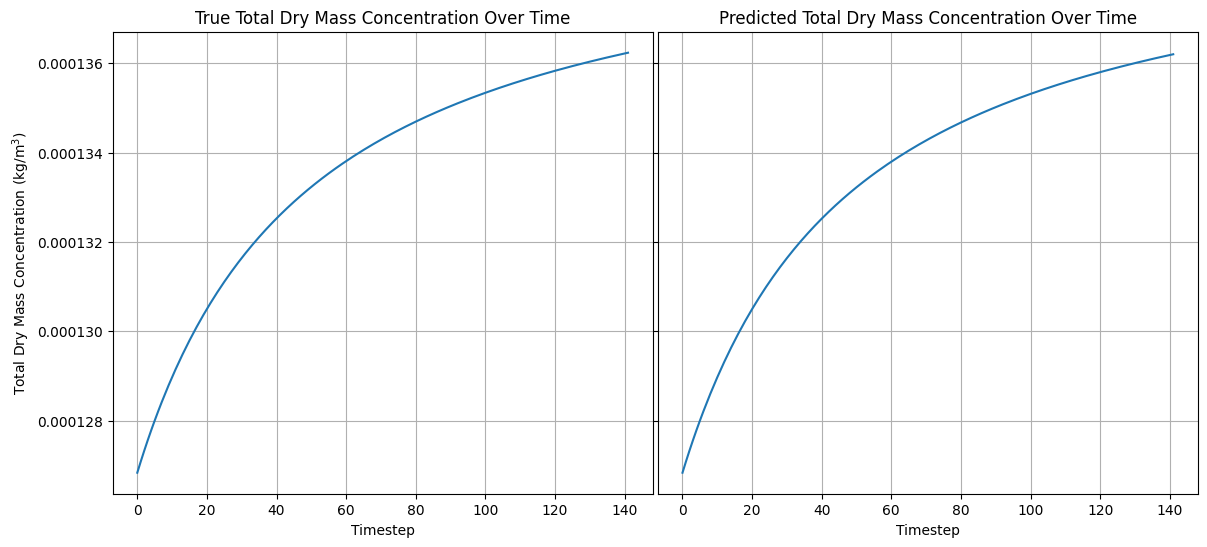

In [174]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)
ax1.plot(ar.mass_concentration(true_dry_mass, mat_prop['aero_number'], chem='all'))
ax2.plot(ar.mass_concentration(pred_dry_mass, mat_prop['aero_number'], chem='all'))

# Add labels and title
ax1.set_xlabel('Timestep')
ax2.set_xlabel('Timestep')
ax1.set_ylabel('Total Dry Mass Concentration (kg/m$^3$)')

ax1.set_title('True Total Dry Mass Concentration Over Time')
ax2.set_title('Predicted Total Dry Mass Concentration Over Time')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.01)

# Show plot
ax1.grid(True)
ax2.grid(True)
plt.savefig("dm_conc_rep15.png")

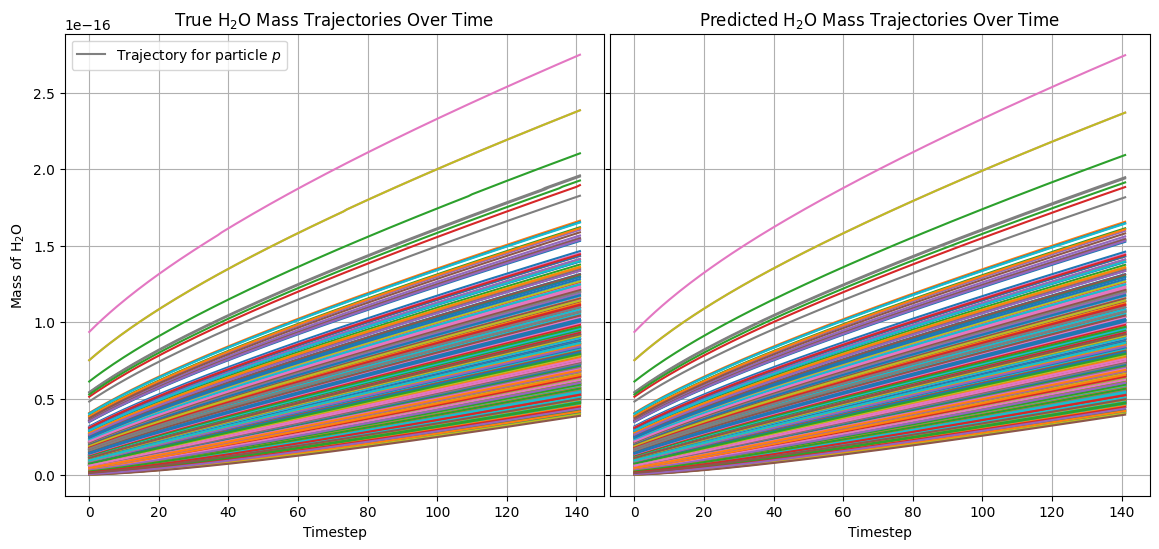

In [175]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)
ax1.plot(true_x['H2O'])
ax2.plot(pred_x['H2O'])

# Add labels and title
ax1.set_xlabel('Timestep')
ax2.set_xlabel('Timestep')
ax1.set_ylabel('Mass of H$_2$O')

ax1.set_title('True H$_2$O Mass Trajectories Over Time')
ax2.set_title('Predicted H$_2$O Mass Trajectories Over Time')

# Add legend for trajectories
ax1.plot([], [], color='gray', label='Trajectory for particle $p$')
ax1.legend(loc='upper left', frameon=True)

# Adjust space between subplots
plt.subplots_adjust(wspace=0.01)

# Show plot
ax1.grid(True)
ax2.grid(True)
plt.savefig("h2orep15.png")

In [176]:
ar.nmae(true_x['H2O'], pred_x['H2O'])

0.0036033685223759073

In [177]:
total_true_drymass = sum(true_dry_mass.values())

In [178]:
total_pred_drymass = sum(pred_dry_mass.values())

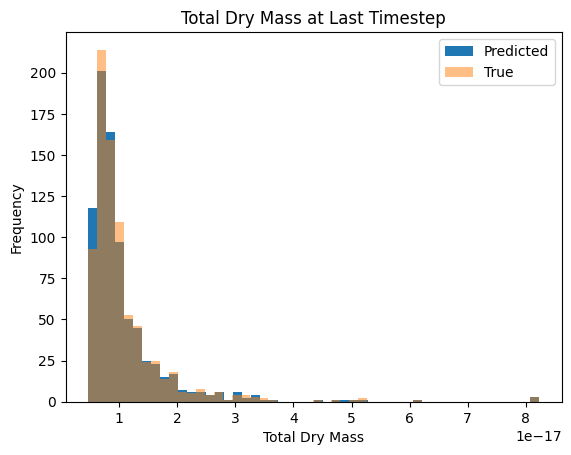

In [179]:
fig, ax = plt.subplots()
ax.hist(total_pred_drymass[-1,:], bins=50, label="Predicted")
ax.hist(total_true_drymass[-1,:], bins=50, alpha=0.5, label="True")
# Add labels and title
plt.xlabel('Total Dry Mass')
plt.ylabel('Frequency')
plt.title('Total Dry Mass at Last Timestep')
# Add legend
plt.legend()
plt.savefig("dm_hist_rep15.png")

In [180]:
mat_prop['aero_number'].shape

(142, 808)

In [181]:
dNdt = mat_prop['aero_number'][1:,:] - mat_prop['aero_number'][:-1,:]

In [182]:
true_Ddry = ar.gd_from_vol(ar.volume('SO4', true_dry_mass) + ar.volume('BC', true_dry_mass) + ar.volume('OC', true_dry_mass))

In [183]:
pred_Ddry = ar.gd_from_vol(ar.volume('SO4', pred_dry_mass) + ar.volume('BC', true_dry_mass) + ar.volume('OC', true_dry_mass))

In [184]:
true_dDdrydt = true_Ddry[1:,:] - true_Ddry[:-1,:]

In [185]:
pred_dDdrydt = pred_Ddry[1:,:] - pred_Ddry[:-1,:]

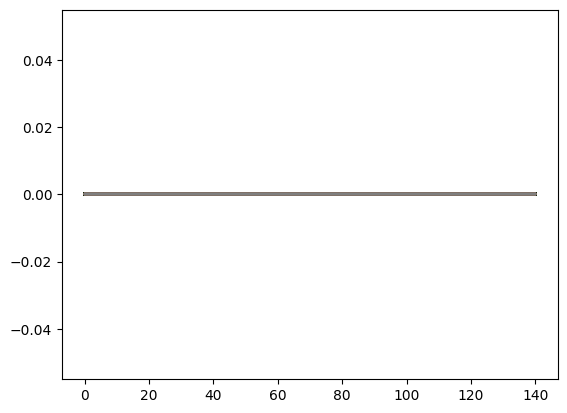

In [186]:
plt.plot(dNdt / pred_dDdrydt)
plt.show()

In [187]:
true_gmean, true_gstd = ar.mean_std_diameter(true_dry_mass)
pred_gmean, pred_gstd = ar.mean_std_diameter(pred_dry_mass)

In [188]:
diams = np.logspace(-9,-6, true_gmean.shape[0])

In [189]:
true_Ddry[-1,:].shape

(808,)

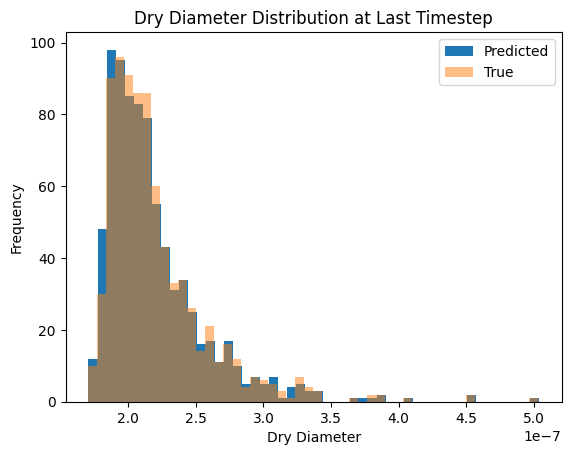

In [190]:
fig, ax = plt.subplots()
ax.hist(pred_Ddry[-1,:], bins=50, label="Predicted")
ax.hist(true_Ddry[-1,:], bins=50, alpha=0.5, label="True")
# Add labels and title
plt.xlabel('Dry Diameter')
plt.ylabel('Frequency')
plt.title('Dry Diameter Distribution at Last Timestep')
# Add legend
plt.legend()
plt.savefig("dd_hist_rep15.png")

In [191]:
def lognormal_distro(number_conc, diams, gmeans, gstds):
    return ((number_conc / (np.sqrt(2*np.pi) * np.log10(gstds))) * 
            np.exp(-0.5 * ((np.log10(diams) - np.log10(gmeans))**2 / (2 * np.log10(gstds)**2))))

In [192]:
true_nD = lognormal_distro(mat_prop['aero_number'], true_Ddry, true_gmean, true_gstd)
pred_nD = lognormal_distro(mat_prop['aero_number'], pred_Ddry, pred_gmean, pred_gstd)

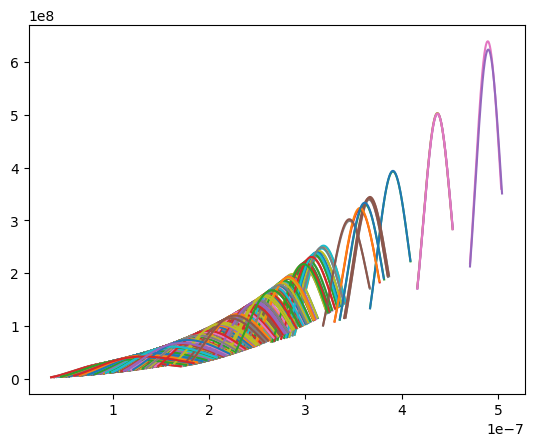

In [193]:
plt.plot(true_Ddry, true_nD)
plt.plot(pred_Ddry, pred_nD)
plt.show()

In [194]:
# for i in range(0, true_drymass.shape[0], 10):
#     fig, ax = plt.subplots()
#     ax.hist(pred_drymass[i,:], bins=100)
#     ax.hist(true_drymass[i,:], bins=100, alpha=0.5)
#     plt.savefig(f"./figures/hists/hist{i}.png")
#     plt.close()